# Exploring expectiles

In [4]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

## Example distribution

We'll want an example multi-modal distribution to play around with. The following code will allow us to work easily with mixtures of multivariate gaussians.

In [2]:
class GMM:
    def __init__(self, coeffs, params):
        self.coeffs = np.array(coeffs)
        self.params = np.array(params)
        self.K = len(coeffs)
        
    def rvs(self, n):
        which_gaussian = np.random.choice(self.K, size=n, p=self.coeffs)
        samples = np.zeros(n)
        for i, (loc, scale) in enumerate(self.params):
            which_samples = (which_gaussian==i)
            count_samples = np.count_nonzero(which_samples)
            samples[which_samples] = stats.norm.rvs(loc, scale, size=count_samples)
        return samples

    def pdf(self, x):
        return sum(c * stats.norm.pdf(x, *ps) for c, ps in zip(self.coeffs, self.params))


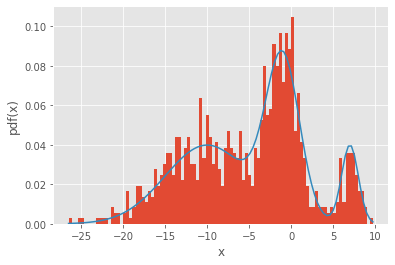

In [3]:
# create a mixture of gaussians
gmm = GMM(coeffs=[0.1, 0.4, 0.5], params=[[7, 1], [-1, 2], [-10, 5]])

# draw and plot a sample of 1000 points for us to play with
np.random.seed(seed=32)
sample = gmm.rvs(1000)
plt.hist(sample, density=1, bins=100)
# plot pdf
x_sample = np.linspace(sample.min(), sample.max(), 100)
y_sample = gmm.pdf(x_sample)
plt.plot(x_sample, y_sample)

plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.show()

$$
\newcommand{\iv }[1]{{[\hspace{-1.5pt}[#1]\hspace{-1.5pt}]}}
\newcommand{\ivt}[3]{{\iv{#1}_{#3}^{#2}}}
$$

## Expectile Regression

Given a distribution $\eta$ with finite second moment, and a $\tau \in [0, 1]$, the $\tau$-expectile of $\eta$, $\epsilon_\tau$ is defined to be the minimising $\epsilon$ of the expectile regression loss $ER(\epsilon; \eta, \tau)$ given by

$$ER(\epsilon;\eta,\tau) = \mathbb{E}_{Z \sim \eta}((\tau\iv{Z \gt \epsilon} + (1-\tau)\iv{Z \leq \epsilon})(Z-\epsilon)^2)$$

ER loss simplifies to

\begin{align*}
    ER(\epsilon;\eta,\tau)
    &=
    \tau\mathbb{E}(\iv{Z \gt \epsilon}(Z-\epsilon)^2) + (1-\tau)\mathbb{E}(\iv{Z \leq \epsilon}(Z-\epsilon)^2)
    \\
    &=
    \tau\int_{z \gt \epsilon}f(z)(z-\epsilon)^2 dz
    \quad
    +
    \quad
    (1-\tau)\int_{z \leq \epsilon}f(z)(z-\epsilon)^2 dz
\end{align*}

where $f(z)$ is the probability density function of the distribution $\eta$.

This shows that the loss is optimised when $\epsilon$ balances a kind of expected squared variation above and below itself, while considering these variations to be unequally important (according to $\tau$ and $1-\tau$, respectively).

#### Notes

ER loss is related to other 'losses' in statistics.

* ER loss is an asymmetric version of the 'square loss', where we consider variation above and below $\epsilon$ equally (as if $\tau=0.5$). The minimiser for the 'square loss' is $\mathbb{E}(Z)$, the *mean*.
* Similarly, we can consider 'quantile regression', where we use the 'quantile loss', an asymmetric version of the absolute value loss. The $\tau=0.5$ quantile is the *median*.

It's in this sense that "expectiles generalise the mean in the same way that quantiles generalise the median".

## Calculating expectiles

The ER loss function is convex and should be easy to numerically optimise. Thus, we can easily calulate $\epsilon_\tau$ of a finite sample's empirical distribution using numerical optimisation:

In [4]:
def ER_loss(eps, tau, sample):
    n = len(sample)
    above_loss = 1/n * np.sum(np.square(sample[sample  > eps] - eps))
    below_loss = 1/n * np.sum(np.square(sample[sample <= eps] - eps))
    return tau * above_loss + (1-tau) * below_loss

def expectile_opt(tau, sample):
    """
    compute sample expectile using optimisation routine
    """
    return opt.minimize(lambda eps: ER_loss(eps, tau, sample), x0=0).x[0]

def expectiles_opt(taus, sample):
    """
    compute sample expectiles for multiple taus using
    optimisation routine
    """
    return [expectile_opt(tau, sample) for tau in taus]




Alternatively, we can express the relationship between $\tau$ and $\epsilon_\tau$ through the derivative of the ER.

\begin{align*}
    -\frac{1}{2}\frac{\partial}{\partial \epsilon} ER(\epsilon;\eta,\tau)
    &=
    \tau\int_{z \gt \epsilon}f(z)(z-\epsilon) dz
    \quad
    +
    \quad
    (1-\tau)\int_{z \leq \epsilon}f(z)(z-\epsilon) dz
    \\
    &=0\qquad\text{(when $\epsilon=\epsilon_\tau$)}
\end{align*}

With some rearrangement, and by introducing

* the cumulative distribution function $F(\epsilon)=\int_{z\leq\epsilon}f(z)dz$,
* the 'partial moment function' $M(\epsilon) = \int_{z\leq\epsilon}z f(z) dz$, and
* the mean $\mu = \int_z z f(z) dz$,

we arrive at the equation:

$$
0
=
 (1-\tau)M(\epsilon_\tau) + \tau(\mu-M(\epsilon_\tau))
-
\epsilon_\tau(
 (1-\tau)F(\epsilon_\tau) + \tau(1-F(\epsilon_\tau))
)
$$

For fixed $\tau$, the RHS expression is a monotonically decreasing function of $\epsilon_\tau$, as shown below for various $\tau$.

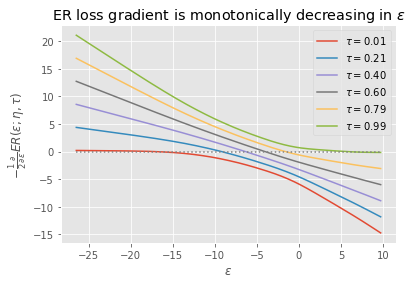

In [5]:
sorted_sample = np.sort(sample)
N = len(sorted_sample)
F = np.cumsum(np.ones_like(sorted_sample)/N)
M = np.cumsum(sorted_sample / N)
mean = M[-1]

for tau in np.linspace(0.01, 0.99, 6):
    prob_balance = ((1 - tau) * F + tau * (1 - F))
    mean_balance = ((1 - tau) * M + tau * (mean - M))
    balance = mean_balance - sorted_sample * prob_balance
    plt.plot(sorted_sample, balance, label=f"$\\tau={tau:.2f}$")

lohi = sorted_sample[0], sorted_sample[-1]
plt.plot(lohi, [0, 0], linestyle=":", color="gray")
plt.ylabel(r"$-\frac{1}{2}\frac{\partial}{\partial \epsilon} ER(\epsilon;\eta,\tau)$")
plt.xlabel(r"$\epsilon$")
plt.title(r"ER loss gradient is monotonically decreasing in $\epsilon$")
plt.legend(loc="upper right")
plt.show()

Moreover, $M$ and $F$ are easily computed cumulatively from a finite sample, and can then be queried efficienty at any sample point (noting that their value only changes at sample points).

This suggests a slightly more direct way to compute $\epsilon_\tau$:

1. Sort the sample.
2. Precompute the partial moments $M$ and cumulative probabilities $F$ at each sample point.
3. Scan through the sample points in increasing order evaluating the derivative, until it first passes 0.
4. The sample expectile will be somewhere between the last two sample points queried.

For simplicy, we could just report the sample point with the lowest absolute gradient as the expectile. Or, since for $\epsilon$ between these two points, $M(\epsilon)$ and $F(\epsilon)$ are constant (and equal to $M(\epsilon_{+})$ and F($\epsilon_{+})$ respectively, where $\epsilon_{+}$ is the final positive-gradient sample point), we can directly solve for the exact expectile:

$$
\epsilon_\tau
=
\frac{
    (1-\tau)M(\epsilon_{+}) + \tau(\mu-M(\epsilon_+))
}{
    (1-\tau)F(\epsilon_+) + \tau(1-F(\epsilon_+))
}
$$




In [6]:
def expectiles(taus, sample, from_sample=False):
    expectiles = []
    n = len(sample)
    sorted_sample = np.sort(sample)
    M = np.cumsum(sorted_sample/n)
    F = np.cumsum(np.ones_like(sorted_sample)/n)
    m = M[-1] # mean
    # candidate expectiles (where M[i], F[i] change):
    eps = sorted_sample
    # for each tau:
    # find the eps where this equation is satisfied:
    # 0 = (1-tau)M(eps) + tau(m-M(eps)) - eps((1-tau)F(eps) + tau(1-F(eps)))
    for tau in taus:
        imbalance = (1-tau)*M + tau*(m-M) - eps*((1-tau)*F + tau*(1-F))
        i = np.argmin(np.abs(imbalance))
        if from_sample or imbalance[i] == 0:
            eps_star = eps[i]
        # optionally, refine answer to *exact* expectile in case it's
        # between two sample points:
        elif imbalance[i] > 0:
            # go a little further!
            eps_star = ((1-tau)*M[i] + tau*(m-M[i])) / ((1-tau)*F[i] + tau*(1-F[i]))
        else:
            # go back a little bit!
            eps_star = ((1-tau)*M[i-1] + tau*(m-M[i-1])) / ((1-tau)*F[i-1] + tau*(1-F[i-1]))
            # TODO: handle case where i=0 already...! when tau=0, or is it when tau=1?
        expectiles.append(eps_star)
    return expectiles

def expectile(tau, sample, from_sample=False):
    return expectiles([tau], sample, from_sample=from_sample)[0]

The direct method for calculating the sample expectile is slightly faster than the optimisation-based method, presumably because of the savings gained by pre-computing the partial moments and cumulative probabilities, and, further, sharing these across various values of $\tau$.

In [7]:
# compute 99 expectiles between tau=1% and tau=99%
taus = np.linspace(0.01, 0.99, 99)

print("direct method")
%timeit expectiles(taus, sample)

print("\nopt-based method")
%timeit expectiles_opt(taus, sample)

direct method
7.16 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

opt-based method
323 ms ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Further, the approximation of using a sample point as the expectile seems to be fair, at least when we have so many samples as in this case (there is likely to be one close to the true value of the expectile).

total absolute error from approximating optimum using a sample point
1.4219332613728513


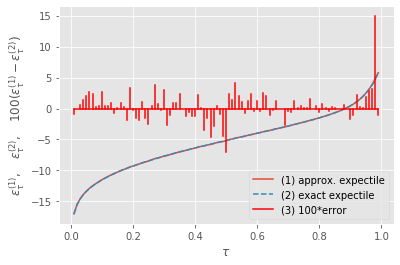

In [8]:
taus = np.linspace(0.01, 0.99, 99)

r1 = np.array(expectiles(taus, sample, from_sample=True ))
r2 = np.array(expectiles(taus, sample, from_sample=False))

print("total absolute error from approximating optimum using a sample point")
print(np.sum(np.abs(r2-r1)))

plt.plot(taus, r1, linestyle="-",  label="(1) approx. expectile")
plt.plot(taus, r2, linestyle="--", label="(2) exact expectile")

for t, d in zip(taus, 100*(r1-r2)):
    plt.plot([t,t], [0,d], color="red")
plt.plot([0.01, 0.99], [0, 0], color="red", label="(3) 100*error")

plt.legend(loc="lower right")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\epsilon_\tau^{(1)},\quad\epsilon_\tau^{(2)},\quad100(\epsilon_\tau^{(1)}-\epsilon_\tau^{(2)})$")
plt.show()

## Plotting expectiles

We can show the expeciles as vertical bars on a histogram, or we can plot the expectiles of a distribution as a function of $\tau \in [0, 1]$.

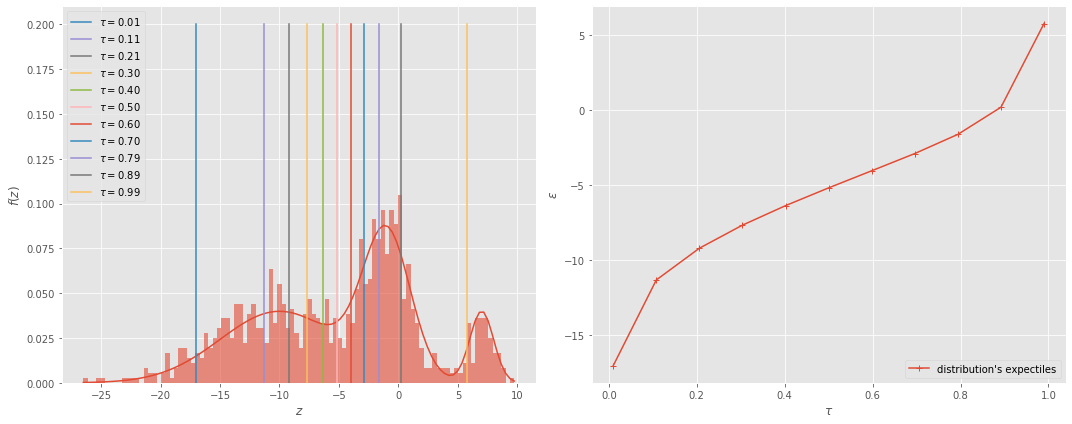

In [9]:
taus = np.linspace(0.01, 0.99, 11)
epss = expectiles(taus, sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(x_sample, y_sample)
ax1.set_prop_cycle(None)
ax1.hist(sample, density=1, alpha=0.6, bins=100)
for tau, eps in zip(taus, epss):
    ax1.plot([eps, eps], [0, 0.2], label=f"$\\tau={tau:.2f}$")

ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

ax2.plot(taus, epss, marker='+', label='distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Imputing expectiles

*Imputation* is the process of 'reconstructing' a distribution given a set of expectiles, so that the distribution has those same expectiles.

Formally, given $\tau_i$ and $\epsilon_{\tau_i}$ for $i = 1, \ldots, K$, we seek a distribution $\eta$ such that for all $i \in \{1,\ldots,K\}$, $\epsilon_{\tau_i} = \text{arg min}_\epsilon ER(\epsilon; \eta, \tau_i)$.

Equivalently, we require that $\frac{\partial}{\partial\epsilon} ER(\epsilon; \eta, \tau_i) |_{\epsilon=\epsilon_{\tau_i}} = 0$ (for all $i \in \{1,\ldots,K\}$), or, framed as an optimisation problem over $\eta$, that

$$
\eta
\in
\text{arg min}_\eta
    \sum_{i=1}^K
    \left(
        \frac{\partial}{\partial\epsilon}
        ER(\epsilon; \eta, \tau_i)
        |_{\epsilon=\epsilon_{\tau_i}}
    \right)^2
$$

Note that given any finite set of expectiles, there may be multiple distributions satisfying the constraints given by those expectiles. We will be satisfied with any such distribution.

In particular, if we assume that the distribution is an empirical distribution on $N$ sample points $z_1, \ldots, z_N$ (with $\eta = \sum_{i=1}^{N} \frac{1}{N} \delta_{z_i}$) then the problem is convex and 'particularly tractable', according to the DeepMind paper (their stochastic expetile distributional reinforcement learning algorithm uses $N=K$ and a default scipy optimiser to solve the problem).

In [10]:
def grad_q_half_ER_loss(eps, tau, sample):
    n = len(sample)
    above_grad_loss = 1/n * np.sum(eps - sample[sample  > eps])
    below_grad_loss = 1/n * np.sum(eps - sample[sample <= eps])
    return tau * above_grad_loss + (1-tau) * below_grad_loss
# TODO: I think I could make this more direct using the same kinds of ideas
# as above for the direct computation of the expectiles, and it should
# improve the efficiency of the optimisation process...!

def impute(taus, epss, n, method='min', start='uniform'):
    tes = np.array(list(zip(taus, epss)))

    if start == 'uniform':
        # initialise as uniform distribution between most
        # extreme expectiles
        z0 = np.linspace(epss[0], epss[-1], n)
    elif start == 'bestof1000':
        # this is implemented for 2020 paper to
        # 'significantly improve optimum found'
        # (note: they also repeat this 10 times)
        zs = np.random.uniform(epss[0], epss[-1], (1000, n))
        z0 = zs[np.argmin([sum(ER_loss(eps, t, z) for t, e in zip(taus, epss)) for z in zs])]
    if method=='root':
        k = len(tes)
        if n != k:
            raise Exception("Hey! This method requires n=k (number of expectiles)")
        def q_gradient(sample):
            grad = np.zeros(n)
            grad[:k] = [grad_q_half_ER_loss(e, t, sample) for t, e in tes]
            return grad
        return opt.root(q_gradient, x0=z0).x
    elif method=='min':
        def sum_square_grads(sample):
            return sum(grad_q_half_ER_loss(e, t, sample)**2 for t, e in tes)
        return opt.minimize(sum_square_grads, x0=z0).x

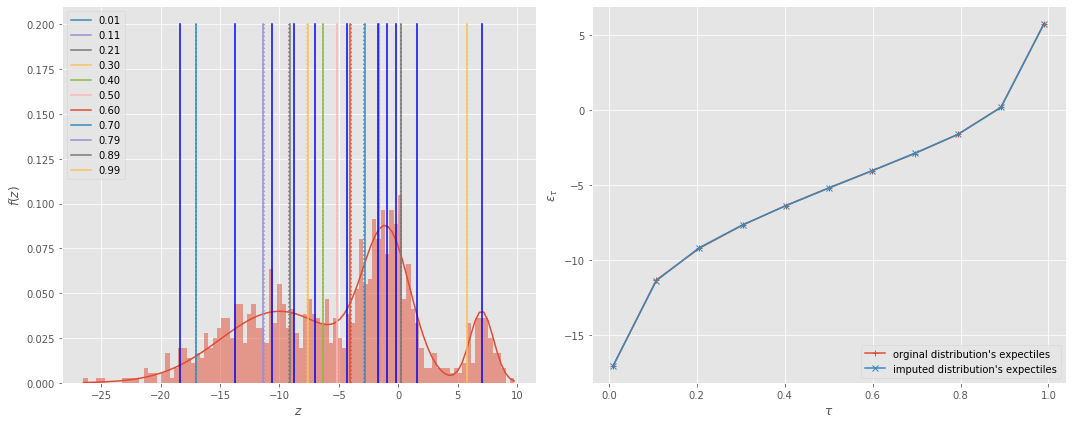

In [11]:
# compute and impute
taus = np.linspace(0.01, 0.99, 11)
epss = expectiles(taus, sample)
imputed_sample = impute(taus, epss, n=len(taus), method='root', start='bestof1000')
imputed_expectiles = expectiles(taus, imputed_sample)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# original sample and expectiles

ax1.set_prop_cycle(None)
ax1.hist(sample, density=1, alpha=0.5, bins=100)
for t, e in zip(taus, epss):
    ax1.plot([e, e], [0, 0.2], linestyle=':')
# new expectiles
ax1.set_prop_cycle(None)
ax1.plot(x_sample, y_sample)
for t, e in zip(taus, imputed_expectiles):
    ax1.plot([e, e], [0, 0.2], label=f"{t:.2f}")
# new sample
for z in imputed_sample:
    ax1.plot([z, z], [0, 0.2], color='blue')
ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

# expectiles plot
ax2.plot(taus, epss, marker='+', label='orginal distribution\'s expectiles')
ax2.plot(taus, imputed_expectiles, marker='x', label='imputed distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon_\tau$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [12]:
def compute_and_impute(taus, sample=sample, n=None, method='min', start='bestof1000'):
    if n is None: n = len(taus)

    # compute
    epss = expectiles(taus, sample)
    
    # impute
    imp_samp = impute(taus, epss, n=n, method=method, start=start)
    imp_epss = expectiles(taus, imp_samp)

    # plot results:
    # histogram of original sample:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    ax1.hist(sample, density=1, alpha=0.5, bins=100, label="original distribution")
    # imputed sample points:
    for z in imp_samp:
        ax1.plot([z, z], [0, 0.01], color='blue')    
    # gaussian-KDE-smoothed imputed sample distribution:
    imp_dist = stats.gaussian_kde(imp_samp, bw_method=0.2)
    imp_support = np.linspace(min(np.min(sample), np.min(imp_samp)), 
                              max(np.max(sample), np.max(imp_samp)))
    ax1.plot(imp_support, imp_dist.pdf(imp_support), label="imputed distribution (smoothed)")


    ax1.set_xlabel("$z$")
    ax1.set_ylabel("$f(z)$")
    ax1.legend(loc="upper left")

    # expectile comparison plot
    full_taus = np.linspace(0.01, 0.99, 99)
    full_epss_old = expectiles(full_taus, sample)
    full_epss_new = expectiles(full_taus, imp_samp)
    ax2.plot(full_taus, full_epss_old, label='orginal distribution\'s expectiles')
    ax2.plot(full_taus, full_epss_new,  label='imputed distribution\'s expectiles')
    ax2.scatter(taus, epss, marker='+')
    ax2.scatter(taus, imp_epss, marker='x')
    ax2.set_xlabel(r'$\tau$')
    ax2.set_ylabel(r'$\epsilon_\tau$')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

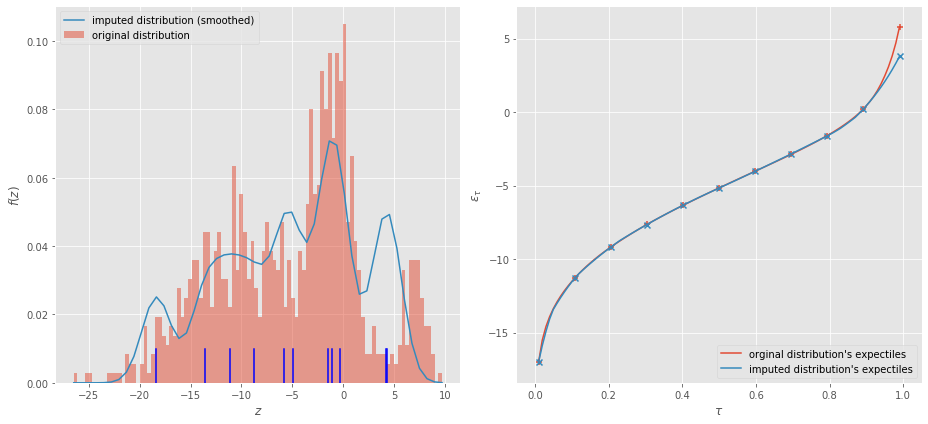

In [13]:
compute_and_impute(taus=np.linspace(0.01, 0.99, 11))

## Playing with the taus

What effect does changing the distribution of expectile biases have on the recovered distribution?

Here I'll use the previously developed sample and imputation methods along with gaussian KDE-smoothing to explore the effect of the tau range on the recovered distribution.

#### What if we nuke the optimistic (or pessimistic) taus?

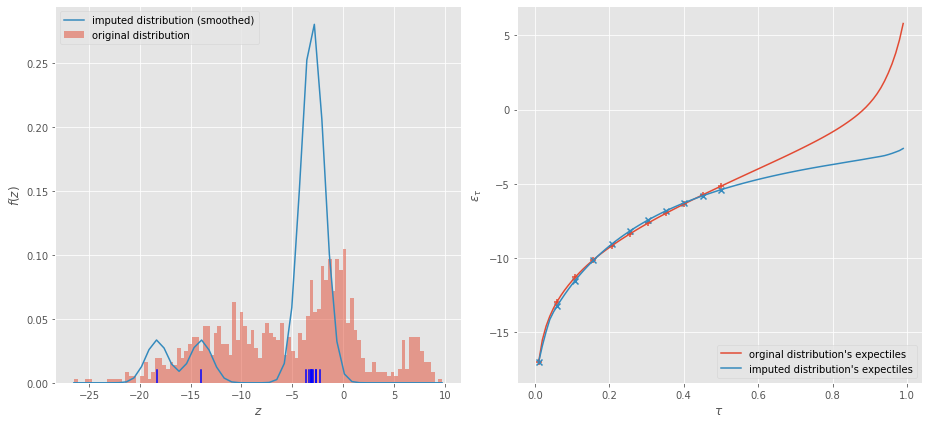

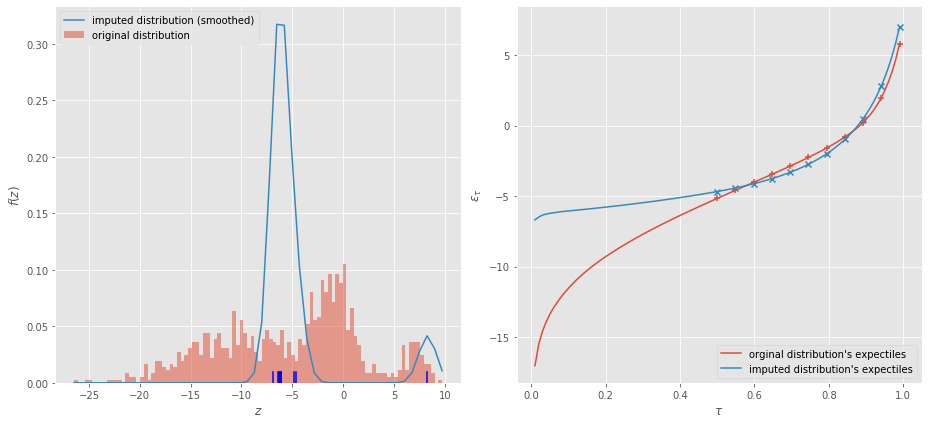

In [14]:
compute_and_impute(taus=np.linspace(0.01, 0.50, 11))
compute_and_impute(taus=np.linspace(0.50, 0.99, 11))

Seems like we struggle to reconstruct a broad distribution, with notable lack of fidelity on the nuked side. What would be the effect on prediction of these distributions?

### What if we restrict the range tightly around the mean?

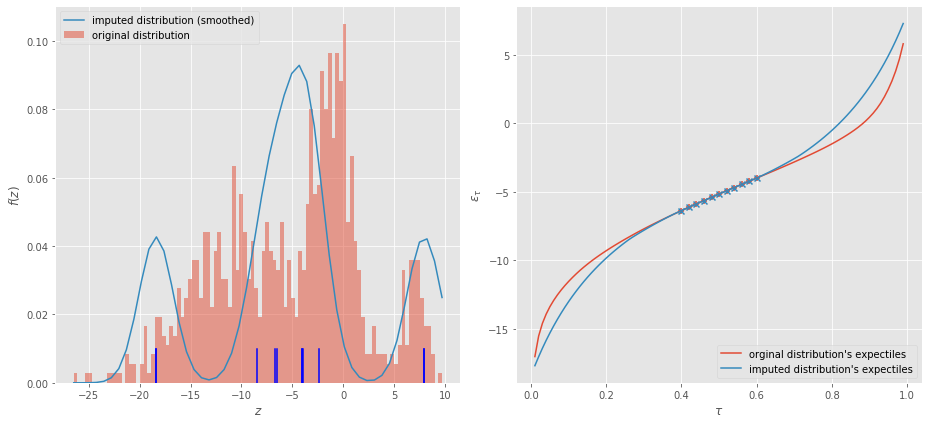

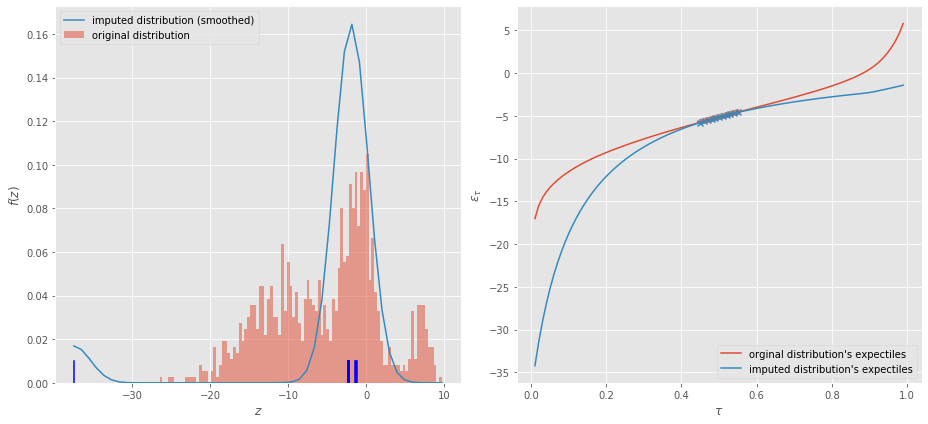

In [15]:
compute_and_impute(taus=np.linspace(0.40, 0.60, 11))
compute_and_impute(taus=np.linspace(0.45, 0.55, 11))

The effect isn't so bad. Well, in the limit, we should recover the mean of the distribution, which was good enough to be state-of-the-art in reinforcement learning until a few years ago!

### What if we use a tight range not including the mean?

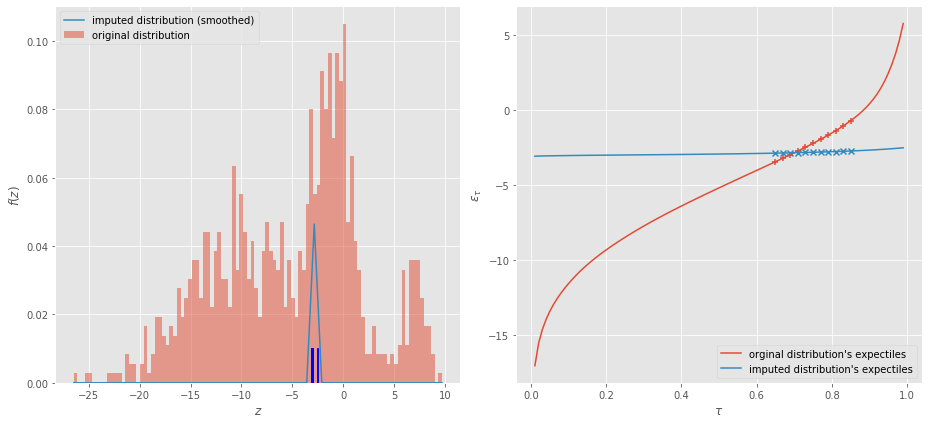

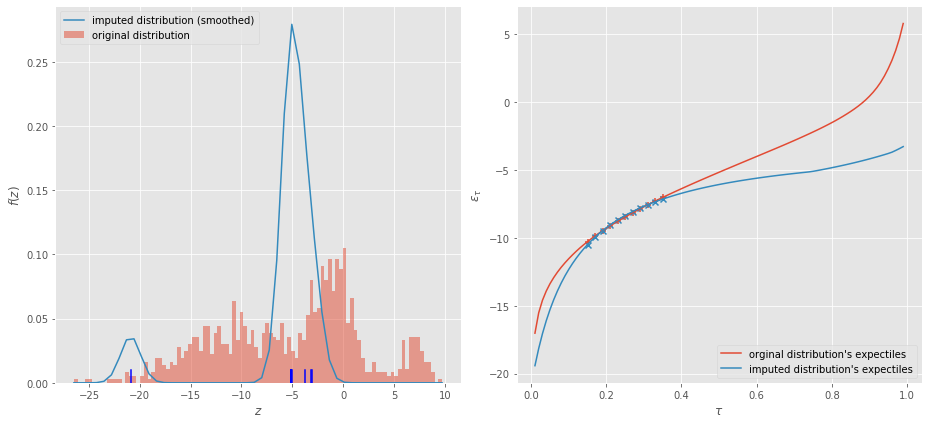

In [16]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 11))
compute_and_impute(taus=np.linspace(0.15, 0.35, 11))

It's like half-way between the other two types.

Notably, it seems that in all cases, we still do a pretty great job of recovering all of the expectiles we kept (how would we go with the ones we didn't keep?).

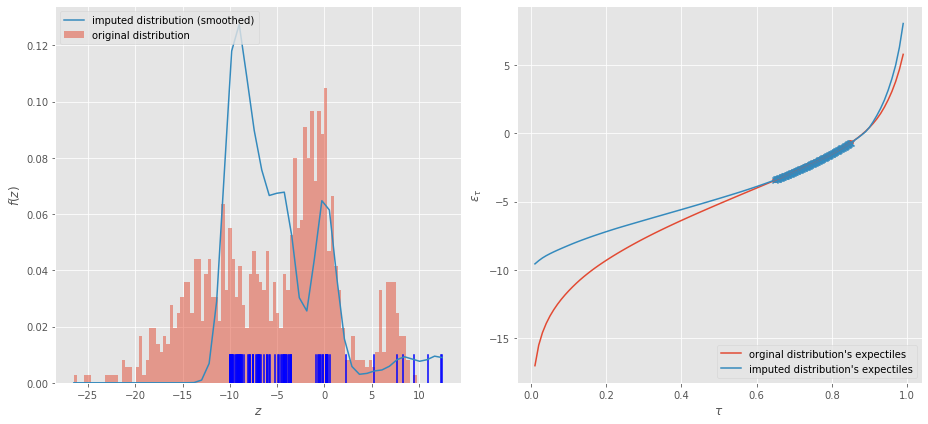

In [17]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 100))

### Maximum entropy imputation

The maximum entropy principle says that if all you have are some observed statistics of an unknown distribution, then the best you can do when recovering the original distribution is to find the distribution with the maximum entropy amongst all distributions with your property. This is the distribution which is 'most similar' to the uniform distribution, whilst still satisfying your observations. It is 'maximally non-committal' beyond the information contained in your observations, so encodes the fewest assumptions.

In our case, our observations are a set of $K$ expectile values (for various asymmetries), $\epsilon_{\tau_i} \doteq \epsilon_i$ for $i=1, 2, \ldots, K$. That is, we require of our distribution $\eta$ that:

$$
-\frac{1}{2} ER'(\epsilon_i; \eta, \tau_i)
=
0
\qquad (i = 1, 2, ..., K)
$$

where
$
ER'(\epsilon_i; \eta, \tau)
=
\frac{\partial}{\partial \epsilon}
ER(\epsilon;\eta,\tau)
|_{\epsilon=\epsilon_i}
$.

Thus, maximum entropy inference suggests that we should solve the following optimisation problem to find $\eta$:

\begin{align*}
\eta
&=
\underset{\text{$\eta$ is a distribution}}{\text{arg max}}~ H[\eta]
\\
\text{s.t.} ~0 &= -\frac{1}{2} ER'(\epsilon_i; \eta, \tau_i) \qquad (i = 1, 2, ..., K)
\end{align*}

To solve this optimisation problem, we can optimise a Lagrangian functional in terms of the pdf of $\eta$, $f$ (with a normalisation constraint).

\begin{align*}
\mathcal{L}[f, \lambda_0, \vec{\lambda} = (\lambda_1, \ldots, \lambda_K)]
&=
-\int_z f(z) \ln f(z) dz
+ \lambda_0 \left( \int_z f(z) dz - 1\right)
+ \sum_{i=1}^K \lambda_i \int_z f(z) (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i} dz
\\
\rightarrow
\frac{\delta\mathcal{L}}{\delta f}
&=
- \frac{\partial}{\partial f(z)} f(z) \ln f(z)
+ \lambda_0  \frac{\partial}{\partial f(z)} f(z)
+ \sum_{i=1}^K \lambda_i \frac{\partial}{\partial f(z)} f(z) (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&= 
- \ln f(z) - 1
+ \lambda_0
+ \sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&\overset{!}{=} 0
\\
\rightarrow f(z)
&=\exp(\lambda_0 - 1) \exp\left(\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}\right)
\\
&=\frac{1}{Z}\exp\left(\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}\right)
~\text{where}~
Z = \int_z\exp\left(\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}\right)dz
\end{align*}

To understand this result, we must inspect the exponent $\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}$. It appears to be a sum of pieceswise linear functions of $z$ (and so is itself a piecewise linear function of $z$). In fact, we can show this:

\begin{align*}
&
\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&=
\sum_{i=1}^K \lambda_i \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i} z
-
\sum_{i=1}^K \lambda_i \epsilon_i \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&=
\left(
  \sum_{i:\epsilon_i \lt  z} \tau_i     \lambda_i
+ \sum_{i:\epsilon_i \geq z} (1-\tau_i) \lambda_i
\right)
z
-
\left(
  \sum_{i:\epsilon_i \lt  z} \tau_i     \lambda_i \epsilon_i
+ \sum_{i:\epsilon_i \geq z} (1-\tau_i) \lambda_i \epsilon_i
\right)
\\
&\doteq
A(z) z + B(z)
\end{align*}

Noting that $A(z)$ and $B(z)$ are flat except where $z\neq \epsilon_i$ for some $i$, we see that this is indeed a piecewise linear function.

What does it look like, for different $\vec{\lambda}$?

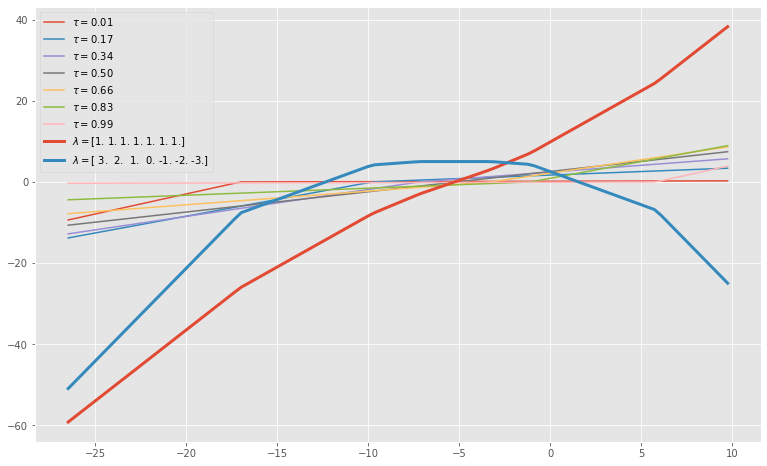

In [18]:

def maxent_exponent_components(taus, sample):
    epss = expectiles(taus, sample) 
    z = np.linspace(sample.min(), sample.max(), 100)
    gte = z[:, np.newaxis]>epss
    R = (z[:, np.newaxis]-epss)*(1-gte-taus+2*taus*gte)
    return z, R
def maxent_exponent(R, lams):
    return np.sum(lams*R, axis=1)

n = 7
taus = np.linspace(0.01, 0.99, n)
z, R = maxent_exponent_components(taus, sample)

plt.figure(figsize=(13, 8))
for tau, r in zip(taus, R.T):
    plt.plot(z, r, label=r"$\tau={:.2f}$".format(tau))

# the result is a weighted sum. what effect do the weights have?
lams = np.ones(n)
plt.plot(z, maxent_exponent(R, lams), linewidth=3, label='$\lambda=${}'.format(lams))
lams = np.linspace(n//2, -(n//2), n)
plt.plot(z, maxent_exponent(R, lams), linewidth=3, label='$\lambda=${}'.format(lams))

plt.legend()
plt.show()

The exponent will clearly diverge, and thus the pdf will be un-normalisable, for the wrong choice of $\vec{\lambda}$.

Can we solve for $\vec{\lambda}$ in general? Applying the expectile constraints:

\begin{align*}
0
&=
\int_z f(z) (z-\epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i} dz
& (i=1, \ldots, K)
\\
&=
\int_z
    \frac{1}{Z}
    \exp\left(\sum_{j=1}^K \lambda_j (z - \epsilon_j) \ivt{z > \epsilon_j}{\tau_j}{1-\tau_j}\right)
    (z-\epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
dz
\\
&=
\int_z
    \exp\left(\sum_{j=1}^K \lambda_j (z - \epsilon_j) \ivt{z > \epsilon_j}{\tau_j}{1-\tau_j}\right)
    (z-\epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
dz
\\
&= \text{... (integration by parts*)}
\\
&=
\frac
{
    \exp
    \left(
        \sum_{j=1}^K \lambda_j \ivt{\epsilon_i > \epsilon_j}{\tau_j}{1-\tau_j} (\epsilon_i - \epsilon_j)
    \right)
}
{
    \left(
        \sum_{j=1}^K \lambda_j \ivt{\epsilon_i > \epsilon_j}{\tau_j}{1-\tau_j}
    \right)^2
}
\end{align*}

This presents a problem... it seems to require that $A(\epsilon_i)$ diverges, which should require some components of $\vec\lambda$ to diverge since the $\epsilon$ and $\tau$ are finite... right?

\*The integration by parts step should be checked. But along the way, we add some new constraints for the integral to be defined: $A(\infty) = \sum_{i=1}^K\tau_i\lambda_i < 0$ and $A(-\infty) = \sum_{i=1}^K(1-\tau_i)\lambda_i > 0$. Together, these define a cone of validity for $\vec\lambda$ as long as $\tau_i \neq 0.5$ for some $i$ (in which case, no $\vec\lambda$ is valid). There's a nice geometric interpretation, and it validates the intuition above that we should use something like $\vec\lambda = [3, 2, 1, 0, -1, -2, -3]$.

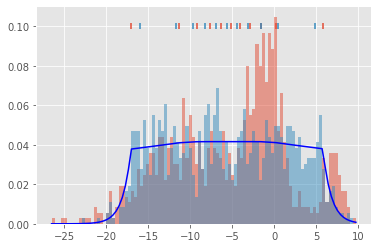

In [19]:
def maxent_pdf(z, R, lams):
    pdf = np.exp(maxent_exponent(R, lams))
    pdf /= np.trapz(pdf, z) # approximate normalisation
    return pdf
def sample_from_pdf(z, pdf, n=1000):
    # rejection sampling to find a sample (to find expectiles:)
    top = pdf.max()
    sample = []
    while len(sample) < n:
        i = np.random.choice(z.size)
        x = np.random.random()*top
        if x < pdf[i]:
            sample.append(z[i])
    return np.array(sample)
    
n = 11
taus = np.linspace(0.01, 0.99, n)
z, R = maxent_exponent_components(taus, sample)

lams = [1, 0.01, 0.01, 0.001, 0.0001, 0, -0.0001, -0.001, -0.01, -0.01, -1]
pdf = maxent_pdf(z, R, lams)
sample2 = sample_from_pdf(z, pdf)

# true dist and expectiles
_,bins,_ = plt.hist(sample, bins=100, density=True, alpha=0.5)
plt.scatter(expectiles(taus, sample),  0.1*np.ones_like(taus), marker="|")

# new dist and expectiles
plt.plot(z, pdf, color="blue")
plt.hist(sample2, bins=bins, density=True, alpha=0.5)
plt.scatter(expectiles(taus, sample2), 0.1*np.ones_like(taus), marker="|")

plt.show()

That's as close as I could get it, and it doesn't look very good...! Also it's weird that a nearly-uniform distribution has very similar expectiles to the highy non-uniform sample we started with...

It should be possible to set the right taus so as so match the original distribution, right? Perhaps playing with asymmetry...

Really, we're trying to get the piecewise linear function in the exponent (including normalisation) to line up with the logarithm of the pdf of the original distribution.

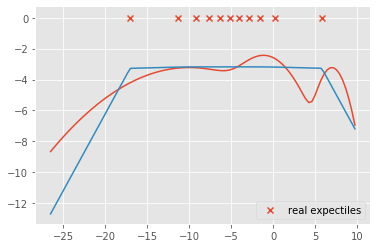

In [20]:

plt.plot(x_sample, np.log(y_sample))
plt.scatter(expectiles(taus, sample) , np.zeros_like(taus), marker="x", label="real expectiles")

lams = [1, 0.01, 0.01, 0.001, 0.0001, 0, -0.0001, -0.001, -0.01, -0.01, -1]
pdf = maxent_pdf(z, R, lams)
plt.plot(z, np.log(pdf))

plt.legend()
plt.show()

OK! The match is actually quite good here... is there a way to nuance it to line up with the kinks in the original?

It will require enough expectiles! Notice that the 'pieces' of the piecewise exponent break at the xpectiles of the original distribution. That means we need expectiles at the points of change of the original distribution if we are going to re-capture the modality in the max-ent imputation. Unfortunately, it seems unlikely that expectiles will end up at these points, since they have such low probability...?

### Other imputation strategies

* Apparently there's a DRL algorithm base don mixtures of gaussians. Since, according to Richard, gaussians are common in neurobiology, this could be worth looking at on the basis of its biological plausibility.

## Learning expectiles

How can we learn expectiles over time by paying attention asymmetrically to positive and negative errors?

We can approximate the mean of a sample by progressively updating as we see sample points. The choice of learning rate determines the stability of the update.

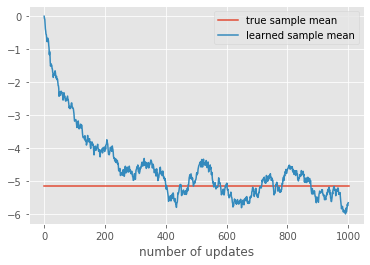

In [21]:
true_mean = np.mean(sample)
plt.plot([0, sample.size+1], [true_mean, true_mean], label="true sample mean")

# or we can approximate this over time
pred_mean = np.zeros(sample.size+1)
learn_rate = 0.01
for t, x in enumerate(sample, 1):
    pred_mean[t] = pred_mean[t-1] + learn_rate * (x - pred_mean[t-1])
plt.plot(pred_mean, label="learned sample mean")
plt.xlabel("number of updates")
plt.legend()
plt.show()

We can do the same for other expectiles, right? We just have to set a different learning rate for positive and negative error updates.

If we use $\alpha_+$ for positive prediction errors (reward greater than the current estimate) and $\alpha_-$ for negative prediction errors (reward less than the current estimate) then the larned value should stabilise at expectile $\epsilon_\tau$ where

$$\tau = \frac{\alpha_+}{\alpha_+ + \alpha_-}$$

That means if we want to learn a particular tau, we should set the rates so that $\alpha_-\tau = \alpha_+(1 - \tau)$, or, equivalently,

$$\alpha_+ = \frac{\tau}{1-\tau}\alpha_-$$

To get the same (geometric?) average learning rate as in the symmetric case, in an attempt to maintain stability, we can set both rates based on a single chosen $\alpha$:

$$
\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}
\qquad
\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}
$$

Let's try that!

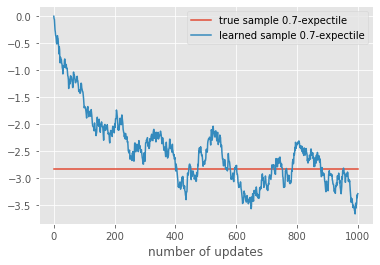

In [22]:
tau = 0.7
true_eps = expectile(tau, sample)
plt.plot([0, sample.size+1], [true_eps, true_eps], label=f"true sample {tau}-expectile")

pred_eps = np.zeros(sample.size+1)
learn_rate_factor = np.sqrt(tau/(1-tau))
avg_learn_rate = 0.01
neg_learn_rate = avg_learn_rate / learn_rate_factor
pos_learn_rate = avg_learn_rate * learn_rate_factor
for i, x in enumerate(sample, 1):
    if x > pred_eps[i-1]:
        # positive prediction error: sample higher than 'expected'
        pred_eps[i] = pred_eps[i-1] + pos_learn_rate * (x - pred_eps[i-1])
    else:
        # negative prediction error: sample lower than 'expected'
        pred_eps[i] = pred_eps[i-1] + neg_learn_rate * (x - pred_eps[i-1])
        
plt.plot(pred_eps, label=f"learned sample {tau}-expectile")
plt.xlabel("number of updates")
plt.legend()
plt.show()

Let's try it for more expectiles!

learning...
plotting...


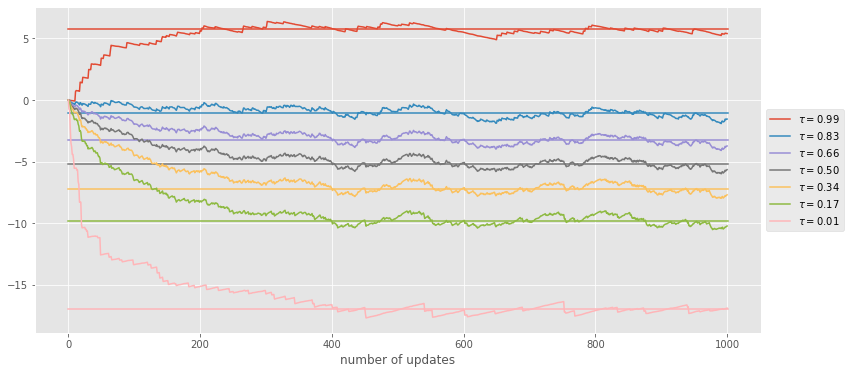

In [23]:
taus = np.linspace(0.01, 0.99, 7)
true_epss = expectiles(taus, sample)
pred_epss = np.zeros((sample.size+1, taus.size))

print("learning...")
learn_rate_factors = np.sqrt(taus/(1-taus))
base_learn_rate = 0.01
neg_learn_rates = base_learn_rate / learn_rate_factors
pos_learn_rates = base_learn_rate * learn_rate_factors
for i, x in enumerate(sample, 1):
    # use negative update rate
    learn_rates = neg_learn_rates.copy()
    # except where error was positive
    pos_err = np.where(x > pred_epss[i-1])
    learn_rates[pos_err] = pos_learn_rates[pos_err]
    
    # with these rates, perform the update
    pred_epss[i] = pred_epss[i-1] + learn_rates * (x - pred_epss[i-1])

print("plotting...")
plt.figure(figsize=(13, 6))
for i, (tau, true_eps) in reversed(list(enumerate(zip(taus, true_epss)))):
    (line,) = plt.plot([0, sample.size+1], [true_eps, true_eps], label=r"$\tau={:.2f}$".format(tau))
    plt.plot(pred_epss[:, i], color=line.get_color())
plt.xlabel("number of updates")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

**The idea of setting the learning rates to be geometrically centred around $\alpha$ is crucial!**

I'm not 100% sure that the geometric mean is the right property to center from here, but the effect in the above plot is promising---the learning 'speed' and 'stability' appears uniform accross the range of values.

Let's see what happens if we use the following non-centred rate instead:

$$
\alpha_- = \alpha 
\qquad
\alpha_+ = \alpha \cdot \frac{\tau}{1-\tau}
$$

learning...
plotting...


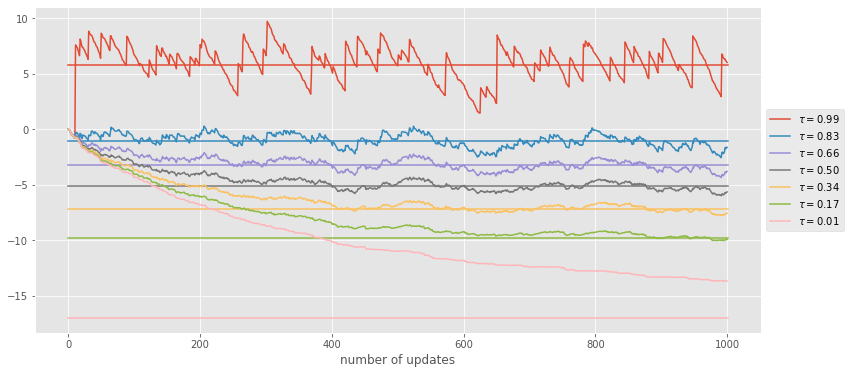

In [24]:
taus = np.linspace(0.01, 0.99, 7)
true_epss = expectiles(taus, sample)
pred_epss = np.zeros((sample.size+1, taus.size))

print("learning...")
learn_rate_factors = np.sqrt(taus/(1-taus))
base_learn_rate = 0.01                                 # DIFFERENCE:
neg_learn_rates = base_learn_rate / learn_rate_factors * learn_rate_factors
pos_learn_rates = base_learn_rate * learn_rate_factors * learn_rate_factors
for i, x in enumerate(sample, 1):
    # use negative update rate
    learn_rates = neg_learn_rates.copy()
    # except where error was positive
    pos_err = np.where(x > pred_epss[i-1])
    learn_rates[pos_err] = pos_learn_rates[pos_err]
    
    # with these rates, perform the update
    pred_epss[i] = pred_epss[i-1] + learn_rates * (x - pred_epss[i-1])

print("plotting...")
plt.figure(figsize=(13, 6))
for i, (tau, true_eps) in reversed(list(enumerate(zip(taus, true_epss)))):
    (line,) = plt.plot([0, sample.size+1], [true_eps, true_eps], label=r"$\tau={:.2f}$".format(tau))
    plt.plot(pred_epss[:, i], color=line.get_color())
plt.xlabel("number of updates")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

The general effect is that the learning rate is systematically scaled based on $\tau$, by a factor of $\sqrt{\frac{\tau}{1-\tau}}$.

Though the system still shows learning stability near the middle of the $\tau$ range, the learning rates for deleteriously effects stability for non-mean expectiles. In the extremes, it causes very large updates for large $\tau$ (unstable learning) and very small updates for small $\tau$ ('overstable', inefficient learning).

The difference can be seen by plotting $\alpha_+$ and $\alpha_-$ as a function of $\tau$ in each case:

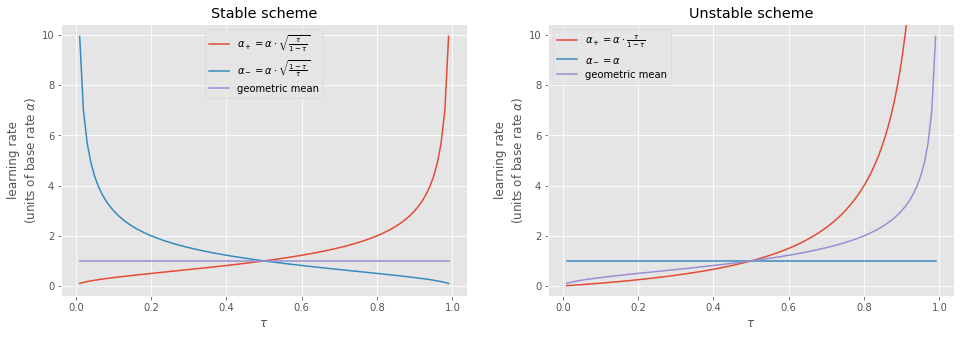

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
x = np.linspace(0.01, 0.99, 99)

y3 = x / (1-x)
y1 = np.sqrt(y3)
y2 = 1 / y1
y4 = np.ones_like(x)
m1 = np.sqrt(y1*y2)
m2 = np.sqrt(y3*y4)

ax1.plot(x, y1, label=r"$\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}$")
ax1.plot(x, y2, label=r"$\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}$")
ax1.plot(x, m1, label="geometric mean")
ax2.plot(x, y3, label=r"$\alpha_+ = \alpha \cdot \frac{\tau}{1-\tau}$")
ax2.plot(x, y4, label=r"$\alpha_- = \alpha$")
ax2.plot(x, m2, label="geometric mean")

ax1.set_title("Stable scheme")
ax1.set_xlabel(r"$\tau$")
ax1.set_ylabel("learning rate\n(units of base rate $\\alpha$)")
ax1.legend()
ax2.set_ylim(ax1.get_ylim())
ax2.set_title("Unstable scheme")
ax2.set_xlabel(r"$\tau$")
ax2.set_ylabel("learning rate\n(units of base rate $\\alpha$)")
ax2.legend()

plt.show()

Really, we want to balance an expected update, rather than the geometric mean, but I don't think it's clear what the expected update should be just given tau.

## Neural data

The deepmind nature paper came with the following neural recording data of optogenetically-modified mouse VTA neurons from a variable-magnitude-reward task (see the paper).

It appears to be a list of **reversal point**, **assymetric scaling** pairs (one per neuron).

* **Reversal point**: The reward amount at which the neuron will switch from eliciing a negative response to a positive response. This is understood to have been be calibrated to a particular expectile of the distribution, after the animals learned the task. Reward magnitudes are in 'estimated utility space' (see paper, methods section).
* **Asymmetric scalings**: The relative magnitude of positive RPE signals and negative RPE signals, $\alpha_+ / (\alpha_+ + \alpha_-)$, estimated for each neuron from response data (by separately estimating the gradient of the response slope for different rewards above and below the reversal point).

In [8]:
# BEGIN DEEP MIND DATA DUMP
# Estimated reversal points and asymmetric scalings from neural recordings
var_mag_values = np.array([(0.14723085014789711, 0.0033614698516132471),
                            (0.28667599774228614, 0.021082047404663212),
                            (0.28748251623549403, 0.049914307764483815),
                            (0.92369323024116956, 0.24368197348648254),
                            (1.3480737534396756, 0.42196866227890156),
                            (1.4125829520026296, 0.2235311630494646),
                            (1.6045034820863808, 0.47702076606215371),
                            (1.7501708044381341, 0.29611582067273567),
                            (3.2848767728849375, 0.3618169272255663),
                            (3.5349203217064185, 0.44251699585808746),
                            (3.7255198380895553, 0.51354237852028162),
                            (4.0160347355202095, 0.29136286695651709),
                            (4.1701645396832827, 0.24596278464602545),
                            (4.3778473672540272, 0.3389597335165157),
                            (4.3819834616604236, 0.4109029572142629),
                            (4.4271922132492669, 0.54775816343621309),
                            (4.5687396324777776, 0.22381550301577841),
                            (4.7432185053035987, 0.98442343982467528),
                            (4.8867786789047276, 0.53931528154401065),
                            (5.1465509369647409, 0.41450775685564373),
                            (5.1545083160041001, 0.56729757738255948),
                            (5.3809271892982986, 0.58246691207675527),
                            (5.4864699584151664, 0.68976626445596256),
                            (5.5322519651782756, 0.34638864585759571),
                            (5.8339188805237727, 0.55480031389511075),
                            (6.2720723207776592, 0.55707650132171915),
                            (6.440584024346915, 0.66221660546254524),
                            (6.5887100296960242, 0.71219295412779748),
                            (6.6818030225629439, 0.65433601123932617),
                            (6.8779347387975447, 0.79852221439758531),
                            (7.8087442676123002, 0.75769015692609276),
                            (8.1264758131781729, 0.70370061384230076),
                            (9.1472582490193517, 0.73113239691022691),
                            (10.202846417424675, 0.63879297718190153),
                            (10.234208410480866, 0.66074850653214368),
                            (10.502672664775268, 0.68294063333022759),
                            (11.277139094915993, 0.7518787167727442),
                            (12.894339210279924, 0.80620103870695436),
                            (13.779164335318981, 0.67485657176374936),
                            (20.0, 0.95602078106395083)])
# END DEEP MIND DATA DUMP

Now, we know these concepts as '$\epsilon_\tau$' and '$\tau$', respectively. So, we have a list of expectiles and taus based on the hypothetical learned reward distribution.

Let's play!

In [9]:
neural_data = var_mag_values
neural_epss, neural_taus = neural_data.T

In [28]:
print("no. neurons:", len(neural_data))

no. neurons: 40


That's the same as in the paper 😅.

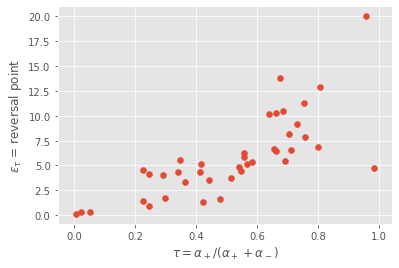

In [29]:
# The tau-expectile plot:
plt.scatter(neural_taus, neural_epss)
plt.ylabel(r"$\epsilon_\tau$ = reversal point")
plt.xlabel(r"$\tau = \alpha_+ / (\alpha_++\alpha_-)$")
plt.show()

Looks similar-*ish* to the plot in the paper (figure **4d**). However, they 1) included curves learned from the ground truth distribution in simulation, and 2) seem to have excluded the top point (it's quite high, and it showed an even higher error bar in figure **4c**).

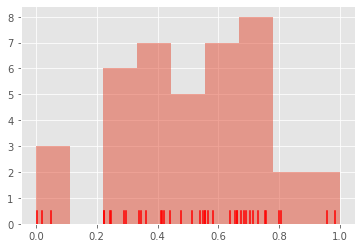

In [30]:
# expectile diversity:
plt.hist(neural_taus, bins=np.linspace(0, 1, 10), alpha=0.5)
for tau in neural_taus:
    plt.plot([tau, tau], [0, 0.5], color="red")
plt.show()

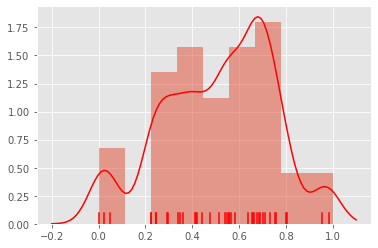

In [31]:
# same PLUS a gaussian-KDE-smoothed version:
plt.hist(neural_taus, bins=np.linspace(0, 1, 10), density=True, alpha=0.5)
for tau in neural_taus:
    plt.plot([tau, tau], [0, 0.1], color="red")
kde_dist = stats.gaussian_kde(neural_taus, bw_method=0.25)
support  = np.linspace(-0.2, 1.1, 100)
plt.plot(support, kde_dist.pdf(support), color="red", label="smoothed distribution (kde bw=0.2)")
plt.show()

Note: KDE probably not appropriate, given that the values are actually only supported over [0, 1] (as probabilities).

Anyway, I wonder where THIS distribution has come from? It doesn't look particularly clean: too centralised to be uniform (?), too spread to be Gaussian (?)

Note: you can't really tell what distribution a sample is from just by eyeballing it: do a statistical test! and for that, this is a very small sample.

What about the inverse logistic function of the biases? This might be sensibly distributed, since it corresponds to the biases arising according to the logistic function, which seems like a reasonable way to produce these asymmetries.

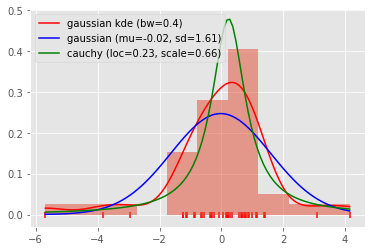

In [32]:
neural_logits = np.log(neural_taus / (1 - neural_taus))
plt.hist(neural_logits, density=True, alpha=0.5)
plt.scatter(neural_logits, np.zeros_like(neural_taus), color='red', marker='|')

# overlay some curves
support  = np.linspace(neural_logits.min(), neural_logits.max(), 100)

# gaussian kde
bw = 0.4
kde_dist = stats.gaussian_kde(neural_logits, bw_method=bw)
plt.plot(support, kde_dist.pdf(support), color="red", label=f"gaussian kde ({bw=})")

# single gaussian
norm_fit = stats.norm.fit(neural_logits)
norm_dist = stats.norm(*norm_fit)
plt.plot(support, norm_dist.pdf(support), color="blue",
         label="gaussian (mu={:.2f}, sd={:.2f})".format(*norm_fit))

# cauchy dist (heavy tails)
cauchy_fit = stats.cauchy.fit(neural_logits)
cauchy_dist = stats.cauchy(*cauchy_fit)
plt.plot(support, cauchy_dist.pdf(support), color="green",
         label="cauchy (loc={:.2f}, scale={:.2f})".format(*cauchy_fit))

plt.legend()
plt.show()

Neither of these (cauchy, gaussian) looks like a particularly great fit. Maybe some statistical tests could make that claim more rigorous. But this would imply that the balances are/are-not distributed in these ways.

### Recovering the distribution

How does this distribution go for OUR sample/reward distribution?

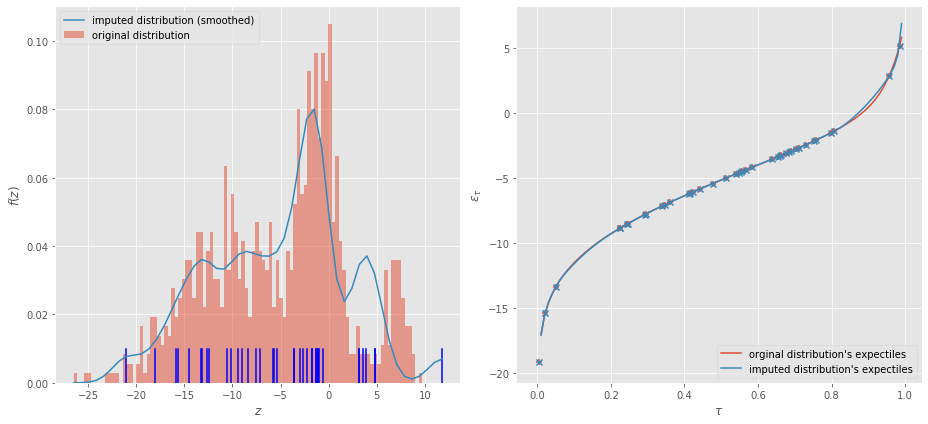

In [33]:
compute_and_impute(taus=neural_taus)

Answer: Spot on! Nails it. However, fewer expectiles probaly would have done the trick too. Come to think of it, there are obviously more than 40 RPE-learning + signaling neurons in a brain. So, it's really just the distribution which matters.

### Learning rates and ratios

The data also came with the following:

In [19]:
# code from deepmind notebook
fig5 = scipy.io.loadmat("Figure5.mat")
zero_crossings = fig5['zeroCrossings'][:, 0]
neg_scale, pos_scale = np.zeros(40), np.zeros(40)
for cell in range(zero_crossings.shape[0]):
    neg_scale[cell] = fig5['scaleFactNeg'][cell, 0]
    pos_scale[cell] = fig5['scaleFactPos'][cell, 0]
# eta = pos_scale/(pos_scale + neg_scale)
# now neg_scale and pos_scale have the respective
# learning rates
# QUESTION: WHAT IS THE DIFFERENCE BETWEEN THESE
# AND THE ONES FROM THE OTHER NOTEBOOK, `neural_taus`
# ABOVE?

Let's see how this measures up to the 'stable scheme' hypothesised above.

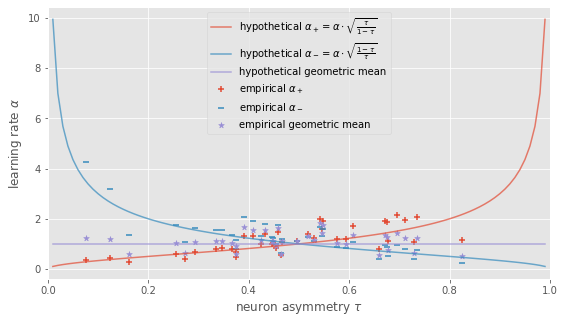

In [37]:
# My stability theory from above predicts:
theory_taus = np.linspace(0.01, 0.99, 99)
theory_apos = np.sqrt(theory_taus / (1-theory_taus))
theory_aneg = 1 / theory_apos
theory_mean = np.ones_like(theory_taus) # = np.sqrt(theory_apos * theory_aneg)

# the experiment reveals:
empirical_apos = pos_scale
empirical_aneg = neg_scale
empirical_taus = empirical_apos / (empirical_apos + empirical_aneg)
empirical_mean = np.sqrt(empirical_apos * empirical_aneg)

# let's see what happens!
plt.figure(figsize=(9, 5))
plt.plot(theory_taus, theory_apos, alpha=0.7, label=r"hypothetical $\alpha_+ = \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}$")
plt.plot(theory_taus, theory_aneg, alpha=0.7, label=r"hypothetical $\alpha_- = \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}$")
plt.plot(theory_taus, theory_mean, alpha=0.7, label="hypothetical geometric mean")
plt.scatter(empirical_taus, empirical_apos, marker="+", label=r"empirical $\alpha_+$")
plt.scatter(empirical_taus, empirical_aneg, marker="_", label=r"empirical $\alpha_-$")
plt.scatter(empirical_taus, empirical_mean, marker="*", label="empirical geometric mean")
plt.xlim([0, 1])
plt.xlabel(r"neuron asymmetry $\tau$")
plt.ylabel(r"learning rate $\alpha$")
plt.legend()
plt.savefig("learning_rate_stability.png")
plt.show()

Holy shit, that's one striking fit!

## Signalling RPEs

The hypothesis goes that these 'neurons' are responsible for calculating and signalling RPEs. The response is determined by the positive or negative rate and the reversal point. I expect that the average response will matter for downstream learning (maybe this is not the case, and downstream neurons tune in to signals of a particular asymmety for some reason...?). If so, it will be a weighted average according to the asymmetry distribution. Let's investigate how this signal varies in response to the magnitude of a reward!

In [34]:
def rpe_signal_spectrum(taus, sample, base_learn_rate=0.01):
    taus = np.array(taus)
    epss = np.array(expectiles(taus, sample))

    learn_rate_factors = np.sqrt(taus/(1-taus))
    # note: here I am including assumptions about how
    # the learning rates are distributed about a base
    # rate. could use some actual neural data...?
    neg_learn_rates = base_learn_rate / learn_rate_factors
    pos_learn_rates = base_learn_rate * learn_rate_factors
    
    rewards = np.linspace(np.min(sample), np.max(sample), 100)
    responses = np.zeros((100, taus.size))
    for i, x in enumerate(rewards):
        # decide learn rates for each neuron (based on whether
        # signal is above or below expectation)
        learn_rates = neg_learn_rates.copy()
        pos_err = np.where(x > epss)
        learn_rates[pos_err] = pos_learn_rates[pos_err]
        # these determine the response
        responses[i] = learn_rates * (x - epss)
        
    means_response = base_learn_rate * (rewards - np.mean(sample))
    
    plt.fill_between(rewards, responses.max(axis=1), responses.min(axis=1),
            color="gray", alpha=0.5, label="individual neuron responses")
    for j in range(epss.size):
        plt.plot(rewards, responses[:, j], alpha=0.5, color="gray")
    plt.plot(rewards, np.mean(responses, axis=1), linewidth=3,
             label="mean response of all neurons")
    plt.plot(rewards, means_response, linewidth=3,
             label=r"response of $\tau=0.5$ neuron")
    plt.xlabel("reward")
    plt.ylabel("response (reward prediction error)")
    plt.legend()

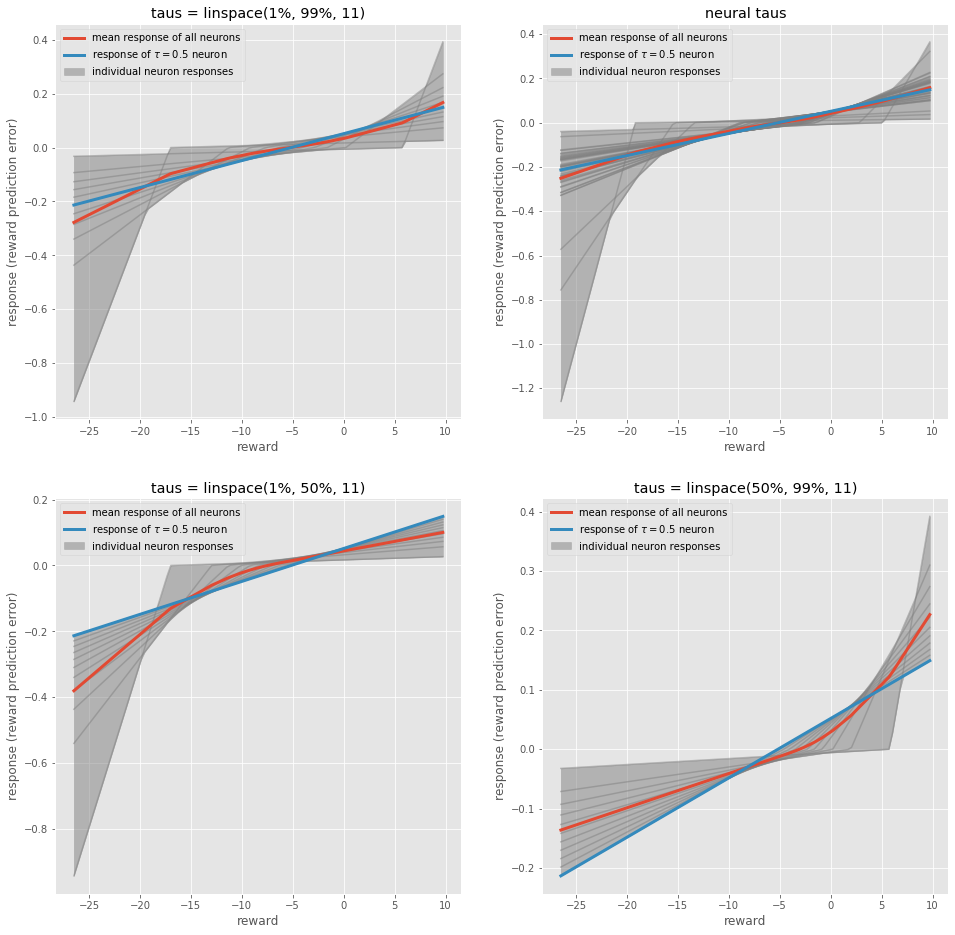

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

ax1.set_title("taus = linspace(1%, 99%, 11)")
plt.sca(ax1)
rpe_signal_spectrum(np.linspace(0.01, 0.99, 11), sample)

ax2.set_title("neural taus")
plt.sca(ax2)
rpe_signal_spectrum(neural_taus, sample)

ax3.set_title("taus = linspace(1%, 50%, 11)")
plt.sca(ax3)
rpe_signal_spectrum(np.linspace(0.01, 0.5, 11), sample)

ax4.set_title("taus = linspace(50%, 99%, 11)")
plt.sca(ax4)
rpe_signal_spectrum(np.linspace(0.5, 0.99, 11), sample)

plt.show()

## Naming asymmetries

$\epsilon$s are 'expectiles', what is a good word for describing the $\tau$s?

Whatever the choice, it should recover the following meanings:

* $\tau=0.5$ implies a 'balanced' expectile,
* $\tau > 0.5$ implies an 'optimistic' expectile,
* $\tau < 0.5$ implies a 'pessimistic' expectile.

### The word

The deepmind paper calls $\tau$ an 'asymetric scaling', or 'asymetric scaling ratio', referring to $\tau = \alpha_+ / (\alpha_+ + \alpha_-)$, where $\alpha$s are 'scalings' (learning rates). They refer to a 'diversity of expectiles' rather than a diversity in expectile-parameters. In the supplemental information, they refer to the $\tau$s as 'asymmetries' (and sometimes use the symbol $\eta$ rather than $\tau$).

How about a term from psychology, such as 'attitude', 'disposition', 'outlook', 'valence'? We can talk about 'distribution of attitudes', for example.

### The scaling

We need not use $\tau \in [0, 1]$ itself, since for example the 0.5 centering may be counter-intuitive.

For example, we could subtract 0.5 to center a quantity at 0, so that 0 corresponds to a 'balanced attitude', positive numbers correspond to 'positive attitude', negative numbers correspond to 'negative attitude'. The measure would range from $[-0.5, 0.5]$.

We could also talk about the ratio $\tau / (1-\tau) \in [0, \infty)$ instead of $\tau$ itself, since this quantity is used in actually setting the learning rates. This is centered (for $\tau=0.5$) at 1.

We could further talk about the *logarithm* of this ratio, for a number in $\mathbb{R}$, also centered a 0 (so 'positive' and 'negative' terminology works).

If we call this quantity $\theta$ then the following relationships hold:

\begin{align*}
\theta
&= \text{logit}(\tau) = \log\left(\frac{\tau}{1-\tau}\right)
&
\tau
&= \text{logistic}(\theta) = \sigma(\theta) = \frac{1}{1+\exp(-\theta)}
\\
\alpha_+
&= \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}
=  \exp\left(\frac{1}{2}\theta\right)
&
\alpha_-
&= \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}
=  \exp\left(-\frac{1}{2}\theta\right)
\end{align*}
        
### The symbol

I can't remember where I got tau from (maybe one of the expectile papers? or deepmind?).

For the logit version, there's no clear choice for a symbol. If we go with 'attitude', the greek word is 'στάση' (stance) or 'διάθεση' (disposition). Neither greek letter is suitable because sigma conflicts with the sigmoid function and delta is used to denote the reward prediction error itself. Neither is alpha from 'αισιοδοξία' (optimism) and 'απαισιοδοξία' (pessimism) suitable, due to the conflict with the learning rate.

Are we stuck with theta with no satisfying reason...?

## Where to from here?

Next questions:

* Can the updates described above lead to an efficient EDRL algorithm?

* The plots above suggest some kind of (measurable?) nonlinear response from an ensemble of asymmetrically tuned dopamine neurons to rewards; is there any empirical evidence of this? Are there limits to the nonlinearity, say, at the lower end due to the negative signal being incodes as an inhibition of baseline response?